In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
#Upperbound para os pontos
N = 300
#Número de hospitais
H = 20
#Número de veículos
K = 50
#Número de Ocorrências
O = 15

In [41]:
#Cria uma matriz de coordenadas (x,y) aleatórias
coord = pd.DataFrame(100*np.random.rand(N,2),index=range(N),columns=["x","y"])
#Verifica se existem dois pontos iguais
if max(coord.value_counts()) > 1:
    count = 0
    for i in coord.value_counts():
        if i>1:
            #e então remove todos os que se aplicarem
            coord.drop(count)
        count+=1
    #por fim reindexando a matriz
    coord.index=pd.RangeIndex(0,len(coord))

In [42]:
#Cria as colunas com os arcos do vértice
coord[1] = coord[2] = coord[3] = coord[4] =-1

In [43]:
#Matriz de distância entre os pontos
_DistanceMatrix = pd.DataFrame(0.0,index=range(len(coord)),columns=range(len(coord)))

In [44]:
#Popula a matriz de distância com
#a distância euclidiana
for i in _DistanceMatrix.index:
    for j in _DistanceMatrix.index:
        dx = (coord.loc[i]["x"]-coord.loc[j]["x"])**2
        dy = (coord.loc[i]["y"]-coord.loc[j]["y"])**2
        _DistanceMatrix.loc[i][j] = (dx+dy)**(1/2)

In [45]:
#Lista de todos os nodos com arcos completos
_ConnectionMatrix = pd.DataFrame(False,index=range(len(coord)),columns=range(len(coord)))
completed = []
d={x:0 for x in _ConnectionMatrix.index}
for i in _ConnectionMatrix.index:
    #Contabiliza o número de conexões já feitas no nodo atual
    n_con = sum(_ConnectionMatrix.loc[i])
    #Se ainda faltar alguma conexão livre
    if n_con < 4:
        #Procura todos os nodos que ainda não foram completados
        incomplete = ~_ConnectionMatrix.index.isin(completed)
        
        #E todos os nodos que ainda não foram preenchidos em 'i'
        free = ~_ConnectionMatrix.loc[i].values
        
        #Ordena em ordem crescente todas as distâncias que satisfazem
        #as duas condições e pega os melhores arcos para completar 'i'
        sort = sorted(_DistanceMatrix.loc[i][incomplete&free])[1:1+(4-n_con)]
        
        #Separa quais os índices dos pontos de chegada determinados
        #na ordenação anterior
        bol = _DistanceMatrix.loc[i].isin(sort)
        
        string = str(i)+": "+str(_ConnectionMatrix.index[~free].values)+" -> "
        #Percorre esses indices
        for j in _DistanceMatrix.loc[i][bol].index:
        
            #Cria o arco 'i_j'
            _ConnectionMatrix.at[i,j] = True
            
            #Cria o arco 'j_i'
            _ConnectionMatrix.at[j,i] = True
            d[j]+=1
            d[i]+=1
            #Se 'j' completar adicionar 'j' na lista de nodos completos
            if sum(_ConnectionMatrix.loc[j]) == 4:
                completed.append(j)
        
        #Se 'i' completar adicionar 'i' na lista de nodos completos
        if sum(_ConnectionMatrix.loc[i]) == 4:
            completed.append(i)
        free = ~_ConnectionMatrix.loc[i].values
        string+= str(_ConnectionMatrix.index[~free].values)
        print(string)

0: [] -> [196 224 264 273]
1: [] -> [  7 140 189 249]
2: [] -> [ 13  44  62 193]
3: [] -> [ 23  35 123 138]
4: [] -> [ 17  29 117 143]
5: [] -> [ 67  75  97 131]
6: [] -> [ 46 118 134 184]
7: [1] -> [  1 103 249 289]
8: [] -> [129 170 180 233]
9: [] -> [ 79  81  85 242]
10: [] -> [ 47  95 175 236]
11: [] -> [ 20 142 149 212]
12: [] -> [110 180 213 276]
13: [2] -> [  2  62 107 193]
14: [] -> [ 83  87  97 297]
15: [] -> [ 35  80 138 254]
16: [] -> [ 18 198 215 263]
17: [4] -> [  4  29 117 247]
18: [16] -> [ 16 198 263 296]
19: [] -> [ 42 126 130 182]
20: [11] -> [ 11 149 188 212]
21: [] -> [167 190 205 255]
22: [] -> [ 80 138 178 254]
23: [3] -> [  3  35 116 138]
24: [] -> [ 33 178 194 257]
25: [] -> [ 66  71 133 287]
26: [] -> [ 73 221 256 267]
27: [] -> [ 60  84  98 235]
28: [] -> [ 91 115 204 292]
29: [ 4 17] -> [  4  17 117 143]
30: [] -> [ 72 108 143 228]
31: [] -> [ 44 121 176 193]
32: [] -> [ 57  69  85 179]
33: [24] -> [ 24  99 178 194]
34: [] -> [171 173 270 278]
35: [ 3 15 23] 

In [47]:
#Verifica se a instância é válida
for i in _ConnectionMatrix.index:
    if sum(_ConnectionMatrix.loc[i]) != 4:
        print(i)
        print(sum(_ConnectionMatrix.loc[i]))

In [48]:
#Preenche os arcos para cada ponto
for i in _ConnectionMatrix.index:
    #Pega todos os nodos em que existe um arco saindo de 'i'
    index = _ConnectionMatrix.index[_ConnectionMatrix.loc[i]]
    count=0
    
    for j in coord.columns[2:2+len(index)]: 
        coord.at[i,j] = index[count] #Adiciona 'ij' aos arcos de 'i'
        count+=1

In [49]:
sinal = 0 #Tempo entre as alterações de estado de um sinal
for i in coord.index:
    for j in coord.loc[i][2:]:
        #Somamos o tempo de cada arco
        if j != -1:
            sinal+=_DistanceMatrix.loc[i][j]
sinal = (sinal/(3*len(coord))) #O tempo de alteração vai ser a média

In [50]:
#Matriz de estado dos arcos entre os sinais
SignalState = pd.DataFrame(False,index = coord.index, columns= coord.columns[2:],dtype=bool)

for i in coord.index:
    for n in coord.loc[i][2:]:
        if n != -1:
            j = int(n)
            #Se o tempo de percorrer o arco 'ij' é menor que o tempo
            #de alteração dos sinais SignalState = True, False caso contrário
            SignalState.loc[i][n] = (_DistanceMatrix.loc[i][j] < sinal)

In [51]:
#Matriz de Estado Instântaneo, representa o estado dos sinais no momento 0
SignalInstantState = pd.DataFrame(False,index = coord.index, columns=["state"], dtype=bool)
SignalInstantState.loc[0]=True

#Nodos já visitados pela busca por profundidade
visited = set()
#Nodo inicial
actual_node = 0

#Busca por profundidade, para encontrar ciclo principal
def dfs(visited,actual_node):
    visited.add(actual_node)
    not_visited = coord.loc[actual_node][2:][~coord.loc[actual_node][2:].isin(visited)]
    if len(not_visited)>0:
        for i in not_visited:
            if i != -1:
                #Pega a coluna que representa o nodo de índice 'i'
                column = coord.loc[actual_node][coord.loc[actual_node] == int(i)].index[0]
                #Realiza um XOR
                xor = SignalState.loc[actual_node][column] != SignalInstantState.loc[actual_node]["state"]
                #Prevê o estado do nodo 'i' no instante 0
                SignalInstantState.loc[int(i)]["state"] = xor
                #Adiciona o nodo 'i'
                visited = dfs(visited,i)
        return visited
            
    else:
        return visited
#Lista dos nodos no ciclo principal
l = dfs(visited,0)

In [52]:
#Todos os índices de ciclos externos
aux = coord.index[~coord.index.isin(l)]
for i in aux:
    #Eliminação de ciclos externos
    coord.drop(i,inplace=True)
len(coord)

300

In [53]:
#Eliminação dos Índices de ciclos externos
SignalInstantState.drop(SignalInstantState.loc[~SignalInstantState.index.isin(coord.index)].index,inplace=True)
SignalState.drop(SignalState.loc[~SignalState.index.isin(coord.index)].index,inplace=True)

In [54]:
#Reindexação Geral
if len(coord) < N:
    for i in range(len(coord)):
        for j in range(len(coord)):
            for k in coord.loc[coord.index[j]][2:].index:
                if coord.loc[coord.index[j]][k] == coord.index[i]:
                    coord.loc[coord.index[j],k] = i
    coord.index = pd.RangeIndex(len(coord))
    SignalInstantState.index = pd.RangeIndex(len(coord))
    SignalState.index = pd.RangeIndex(len(coord))

In [55]:
#Pontos escolhidos como hospitais
hospitais = pd.DataFrame(coord.index[np.random.randint(0,len(coord),H)],columns=["P"])

In [1]:
#Instância dos Veículos
veiculos = pd.DataFrame(index=range(K),columns=["Inicial","LowerBound","UpperBound"])

for i in veiculos.index:
    #Ponto inicial do veículo, escolhido aleatoriamente
    inicial = hospitais.loc[np.random.randint(0,len(hospitais))]["P"]
    #Quantidade do mesmo tipo de veículo no mesmo hospital
    qntd = np.random.randint(1,5)
    #Para cada veículo do mesmo tipo
    for j in range(qntd):
        lb = np.random.randint(1,6)      #Temos a prioridade mínima pela qual ele atende
        ub = np.random.randint(5,11)     #e a prioridade máxima que ele consegue atender
        veiculos.loc[i+j] = [inicial,lb,ub] #Inserção do veículo na instância

NameError: name 'pd' is not defined

In [57]:
#Ocorrências
ocurrences = pd.DataFrame(index=range(O),columns=["P"])
#Pontos que não estejam previamente ocupados por hospitais
aux = coord[~coord.index.isin(hospitais["P"].values)].index
for i in range(O):
    #Escolhe aleatoriamente dentro dos pontos livres
    ocurrences.loc[i]["P"] = aux[np.random.randint(0,len(aux))]
    

In [58]:
#Instância das vítimas
victims = pd.DataFrame(index=range(O),columns=["Ponto","Prioridade"])
for i in range(O):
    #Escolhe dentro dos pontos das ocorrências 
    victims.loc[i] = [ocurrences.loc[i]["P"],np.random.randint(1,11)]

In [59]:
#Salva as instâncias
veiculos.to_csv("k_"+str(K))
victims.to_csv("v_"+str(O))
coord.to_csv("n_"+str(len(coord)))
SignalInstantState.to_csv("si_"+str(len(SignalInstantState)))
SignalState.to_csv("s_"+str(len(SignalInstantState)))

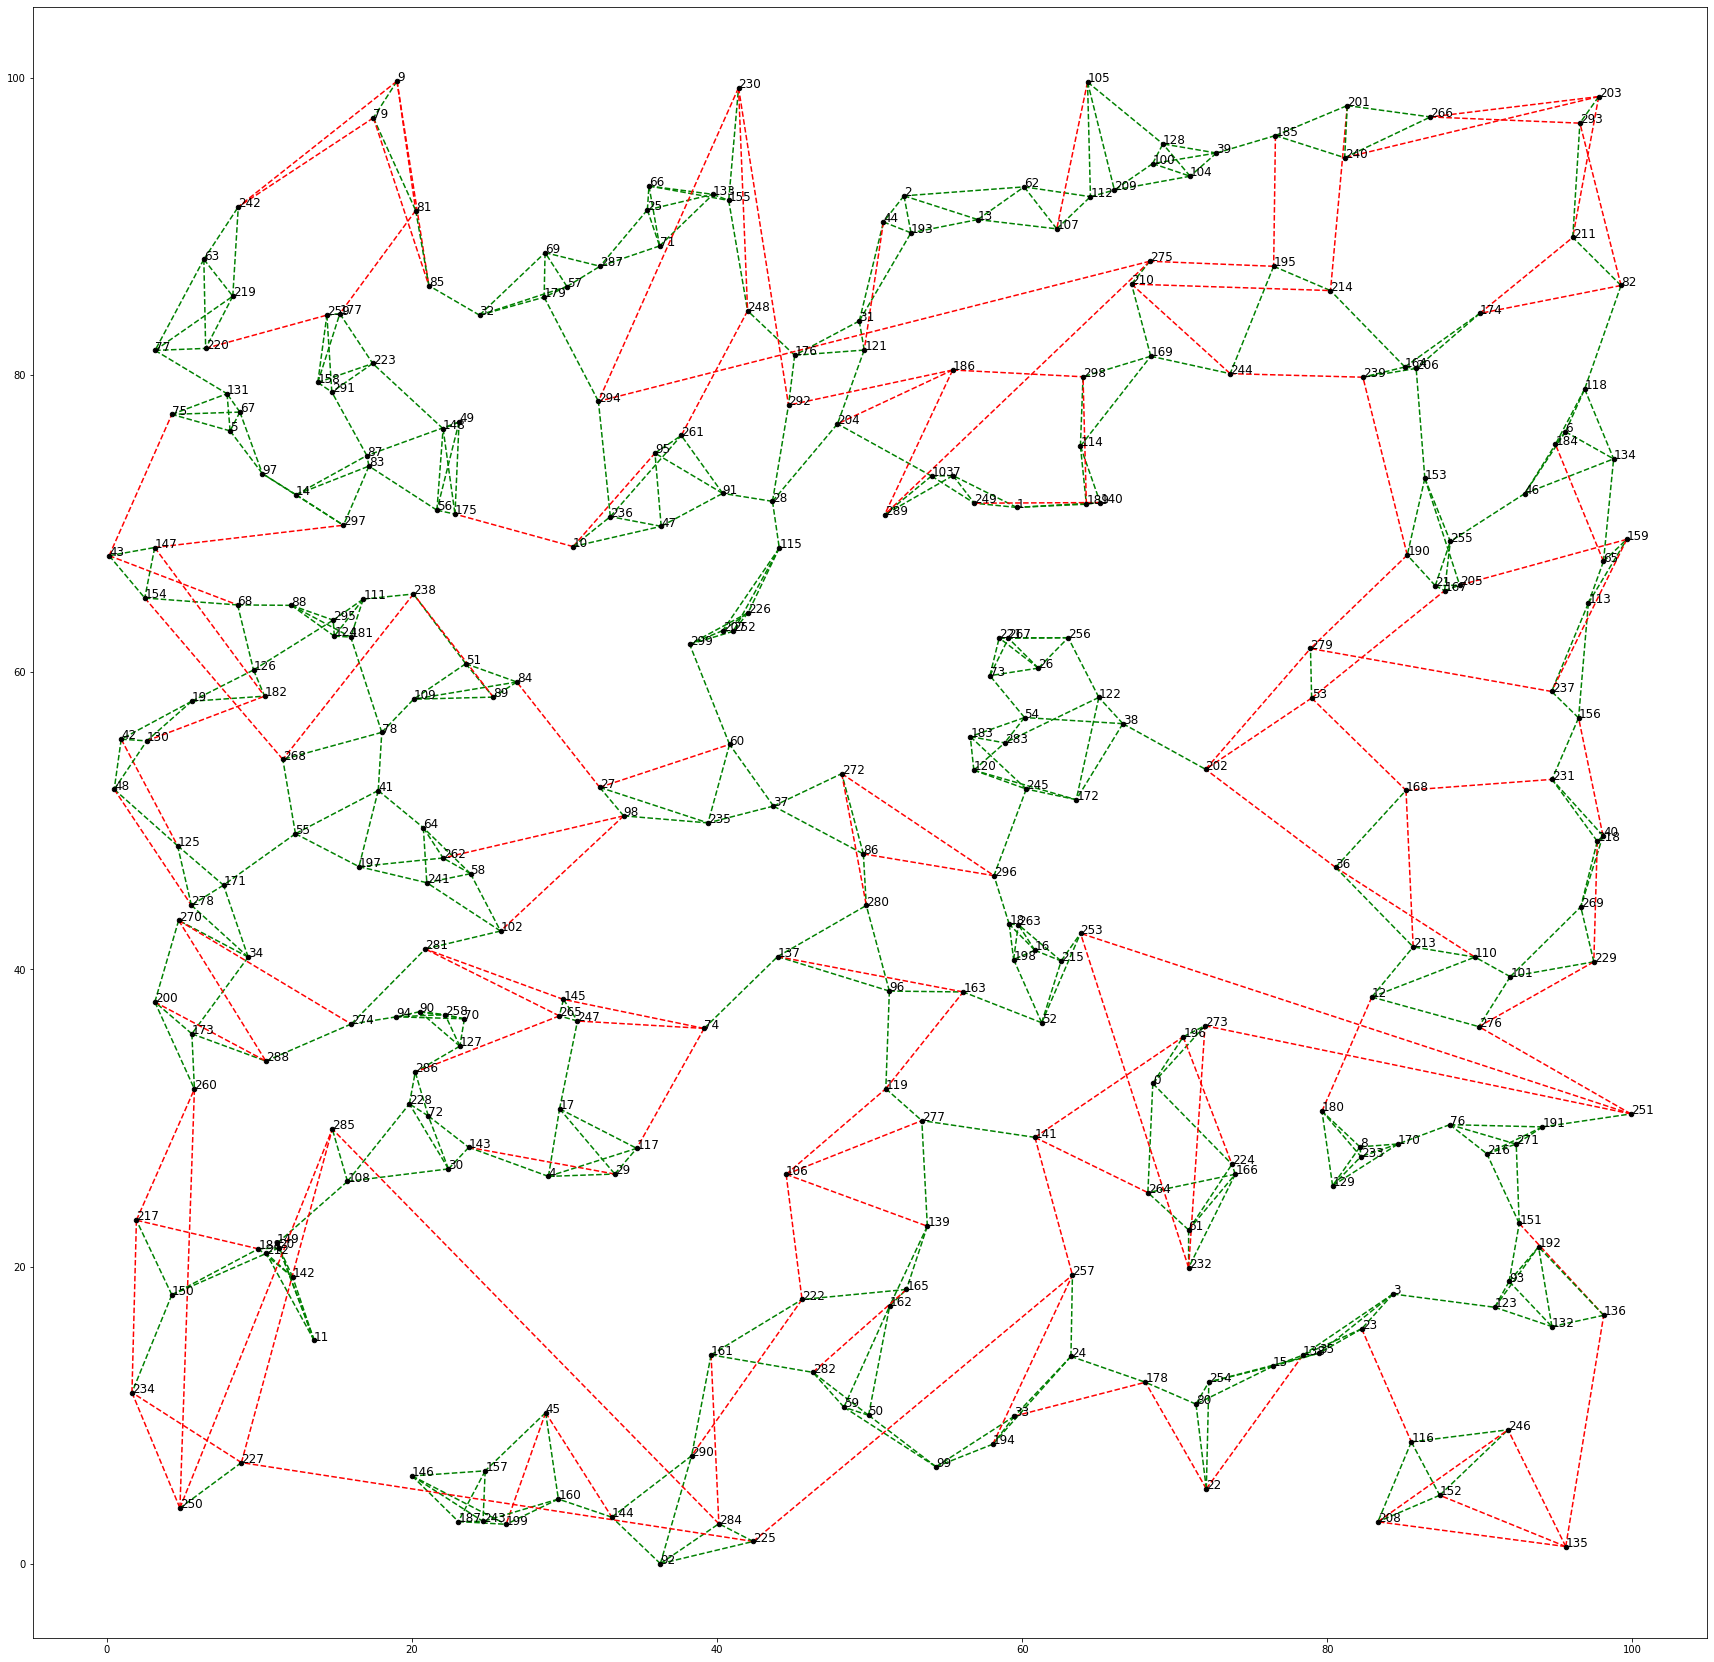

In [60]:
#Gera uma imagem do sistema criado
plt.figure(figsize=(30,30))
for i in coord.index:
    plt.scatter(coord.loc[i]["x"],coord.loc[i]["y"],s=20,color='black',zorder=1)
    plt.text(coord.loc[i]["x"],coord.loc[i]["y"],str(i),fontsize=12)

visitados = {x:[] for x in coord.index}
for i in coord.index:
    l = [int(x) for x in coord.loc[i][2:][coord.loc[i][2:] != -1]]
    xcoord = list(coord.loc[l]['x'].values)
    
    ycoord = list(coord.loc[l]['y'].values)
    
    for j in range(len(xcoord)):
        if l[j] not in visitados[i]:
            if _DistanceMatrix.loc[i][l[j]] < sinal:
                plt.plot([coord.loc[i]["x"],xcoord[j]],[coord.loc[i]["y"],ycoord[j]],'g--',zorder=0)
            else:
                plt.plot([coord.loc[i]["x"],xcoord[j]],[coord.loc[i]["y"],ycoord[j]],"r--",zorder=0)
        visitados[l[j]].append(i)

plt.savefig("n"+str(len(coord)))